<h1>In this notebook, we will test four different methods of orbit integration against each other: Rebound, standard Scipy integrator, leapfrog orbital integrator (written from scratch) and a kick / a series of kicks.</h1>
<p>Here we envision that the binary star is on a very wide orbit and then one of the components suffers a kick. In some cases the binary will get disrupted, and in other cases it will continue on a different orbit. If instead of one kick one of the stars undergoes acceleration for a finite amount of time, this can be represented as a series of kicks, and we'll test this too.
<p>Written by Nadia Zakamska, June 2024

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table
import rebound
from scipy.integrate import solve_ivp

# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

# code values = physical values * these units
vunit=1./29.78
aunit=1./(29.78*2*np.pi)
tunit=2*np.pi

<h2>Example use of the one_kick_loss function in orbital.py (based on the analytical solution)</h2>

In [2]:
# initial orbital parameters
ain=8400. 
eccin=0.68
incin=0.44
asclongin=3.5
omegain=0.15
mean_an_in=0.
m1=0.4
m2=4.3
total_mass=m1+m2
# mass loss of the more massive star -- let's start with a pure velocity kick, no mass loss
# does not handle mass loss well. 
deltam=0.0
# what is the period of this binary, in years? 
print(orbital.per(total_mass,ain))

355878.8965751053


In [3]:
# the dictionary of the orbital parameters
orbit={'sma':np.array(ain), 'ecc':np.array(eccin), 'inc':np.array(incin), 
       'asclong':np.array(asclongin), 'omega':np.array(omegain), 'mean_anomaly':np.array(mean_an_in)}

In [4]:
# This is an example binary which remains bound after the kick:
#
# kick velocity is a vector that affects star m2, it needs to be in Rebound code units 
# where 29.78 km/sec is one velocity unit
vkick=np.array([0.,0.,1.])*vunit # so this is a kick to the 2nd star of 1 km/sec along the z axis
# this is the analytical solution for the new orbit given the masses of the components, the mass loss for m2
# the kick velocity and the initial orbital parameters dictionary:
new_orbit=orbital.one_kick_loss(m1,m2,deltam,vkick,orbit)
new_orbit

sma,ecc,inc,asclong,omega,mean_anomaly
float64,float64,float64,float64,float64,float64
4870.868766932271,0.4497535398351894,0.22240058905250726,0.7802241955605986,2.9859265979916394,6.236628404411899


In [5]:
# and here is a binary that's getting disrupted: same magnitude of velocity kick, but in a different direction
vkick=np.array([0.,0.,-1.])*vunit # so this is a kick to the 2nd star of 1 km/sec
new_orbit=orbital.one_kick_loss(m1,m2,deltam,vkick,orbit)
new_orbit
# anomalies are not meaningful for disrupted orbits and are not being tracked. ecc>1 or sma<0 are both conditions
# that should be satisfied for disrupted orbits, and that's how we know they are disrupted.

sma,ecc,inc,asclong,omega,mean_anomaly
float64,float64,float64,float64,float64,float64
-2236.9772596620787,2.20090838771432,0.8557446735963739,3.5804844516474295,0.04284933192161285,-0.04987258223161728


<h1>Comparison of Rebound, direct integration using the standard built-in integrator, direct integration using leapfrog, and kicks</h1>

In [6]:
ain=8400. 
eccin=0.68
incin=0.44
asclongin=3.5
omegain=0.15
m1=4.3
m2=0.4
total_mass=m1+m2
# mass loss of the more massive star
fm1=0.9
deltam=m1-fm1
mean_an_in=0.
# what is the period of this? 
print(orbital.per(m1+m2,ain))

355878.8965751053


In [7]:
# in physical units
vasym=2. # this is in km/sec
tintegrate=3.e5 # this is in years
timestep=3.e2 # dumping timestep for Rebound
tfinal=tintegrate*tunit # this is in code units
ak_code=vasym*vunit*deltam/(m1*tfinal) # this is in code units. This is not an actual recoil acceleration,
# this is only an approximate value which is constant in time (which is the case that can be handled by Rebound).
# In the calculations in the paper we consider a more general case of acceleration that's a function of time. 

In [8]:
# The Rebound simulation cannot handle varying mass. Therefore only the acceleration is applied. 
# We work in units where G=1.  
sim = rebound.Simulation()
sim.add(m=total_mass)                  # Stationary center of mass
sim.add(m=0., a=ain, e=eccin, inc=incin, Omega=asclongin, omega=omegain, M=mean_an_in) # moving object
sim.move_to_com() # this shouldn't matter because the second particle has 0 mass
ps = sim.particles
print(ps[1])

def reb_ak(reb_sim):
    ps[1].az += ak_code

# Tell rebound which function to call
sim.additional_forces = reb_ak

#sim.integrator = "hermes" 
sim.integrator="whfast"
sim.dt = 1.

# Next, let's do the simulation. tfinal is the max time in code units
# the number of times we record is determined by the timestep
itimes = np.linspace(0,tfinal,int(tintegrate/timestep))
nstep=np.size(itimes)
xyz = np.zeros((nstep, 3))
vxyz = np.zeros((nstep, 3))
for i, itime in enumerate(itimes):
    sim.integrate(itime)
    ps=sim.particles
    xyz[i] = [ps[1].x, ps[1].y, ps[1].z]
    vxyz[i] = [ps[1].vx, ps[1].vy, ps[1].vz]
# compute orbital parameters from the Cartesian trajectory
fsma,fecc,finc,fasclong,fomega,ftrue=orbital.orbital_from_cart(total_mass,xyz,vxyz)


<rebound.particle.Particle object at 0x11be7ae50, m=0.0 x=-2361.445236024174 y=-1272.653420423101 z=171.0954959784452 vx=0.02459268049914577 vy=-0.04256368365636483 vz=0.022826145085577582>


In [9]:
# these are initial conditions
print(total_mass, ain, eccin, incin, asclongin, omegain, mean_an_in)
# let's compute the Cartesian parameters corresponding to these initial conditions. Should be the same as 
# Rebound
rvec0,vvec0=orbital.cart_from_orbital(total_mass, ain, eccin, incin, asclongin, omegain, mean_an_in)
# get rid of some extra brackets
rvec0=rvec0[0]
vvec0=vvec0[0]
print(rvec0,vvec0)
# Yay, same positions and same velocities as in Rebound

4.7 8400.0 0.68 0.44 3.5 0.15 0.0
[-2361.44523602 -1272.65342042   171.09549598] [ 0.02459268 -0.04256368  0.02282615]


In [10]:
big_table=Table([np.array([m1]), np.array([m2]), np.array([fm1]), np.array([ain]), np.array([eccin]), 
          np.array([incin]), np.array([omegain]), np.array([asclongin]), np.array([0.0])], 
          names=['m1', 'm2', 'fm1', 'sma', 'ecc', 'inc', 'omega', 'asclong', 'mean_anomaly'])
# This is what we will actually be doing in our code that goes through objects
# apparently I can't even mess with that one element without risking the big table, so this is what we'll have:
obj=Table(big_table[0], copy=True)
deltam=obj['m1']-obj['fm1']
obj

m1,m2,fm1,sma,ecc,inc,omega,asclong,mean_anomaly
float64,float64,float64,float64,float64,float64,float64,float64,float64
4.3,0.4,0.9,8400.0,0.68,0.44,0.15,3.5,0.0


In [11]:
def tm(t, tf=tfinal):
# total mass as a function of time in code units
    # normally we will consider some function of time, e.g., linearly declining, but Rebound cannot handle this
    # so we start with a constant mass
    #return(obj['m1']+obj['m2']-deltam*t/tf)
    return(obj['m1'][0]+obj['m2'][0])
def ak(t, tf=tfinal):
# the time is in the code units and the acceleration is in the code units
    # normally we will consider acceleration that's commensurate with mass loss from the recoil equation, but
    # for comparison with Rebound we try constant
    #return(vasym*vunit*deltam/(obj['m1']*tf-deltam*t))
    return(ak_code)
def vk(t,dt,tf=tfinal):
    # total kick velocity -- I still can't figure out what the appropriate signs are
    # but it looks like I am adding a - sign to this during the actual intergration of kicks...
    #return(vasym*vunit*np.log(obj['m1']*tf-deltam*t)/(obj['m1']*tf-deltam*(t+dt)))
    return(ak_code*dt)

In [12]:
# sanity check
print('period ',orbital.per(obj['m1']+obj['m2'],obj['sma']))
rvec0,vvec0=orbital.cart_from_orbital(obj['m1']+obj['m2'], obj['sma'], obj['ecc'], obj['inc'], 
                              obj['asclong'], obj['omega'], obj['mean_anomaly'])
rvec=rvec0[0]
vvec=vvec0[0]
print(rvec,vvec)

period         sma       
-----------------
355878.8965751053
[-2361.44523602 -1272.65342042   171.09549598] [ 0.02459268 -0.04256368  0.02282615]


In [13]:
# DIRECT integration using the built-in scipy integrator:
minnum=100
deltat_code=orbital.per(obj['m1'][0]+obj['m2'][0],obj['sma'][0])*tunit/minnum
# this is the total number of steps: 
nsteps=max(minnum, int(tfinal/deltat_code))
t_eval=np.linspace(0, tfinal, nsteps)
def rhs(t, u): 
    r=np.sqrt(u[0]**2+u[1]**2+u[2]**2)
    return ([u[3],u[4],u[5],-tm(t)*u[0]/r**3,-tm(t)*u[1]/r**3,-tm(t)*u[2]/r**3+ak(t)])
dir_res = solve_ivp(rhs, (0, tfinal), [rvec[0], rvec[1], rvec[2], vvec[0], vvec[1], vvec[2]], t_eval=t_eval)
(dir_sma,dir_ecc,dir_inc,dir_asclong,dir_omega,dir_true)=orbital.orbital_from_cart(tm(dir_res.t),dir_res.y[0:3,].T,dir_res.y[3:6,].T)


In [14]:
# DIRECT integration by leapfrog
minnum=100
deltat_code=orbital.per(obj['m1'][0]+obj['m2'][0],obj['sma'][0])*tunit/minnum
# this is the total number of steps: 
nsteps=max(minnum, int(tfinal/deltat_code))
t_eval=np.linspace(0, tfinal, nsteps)
qqx=np.array([rvec[0]])
qqy=np.array([rvec[1]])
qqz=np.array([rvec[2]])
ppx=np.array([vvec[0]])
ppy=np.array([vvec[1]])
ppz=np.array([vvec[2]])
hh=t_eval[1]-t_eval[0]
for j in np.arange(1,nsteps):
    q12x=qqx[j-1]+0.5*hh*ppx[j-1]
    q12y=qqy[j-1]+0.5*hh*ppy[j-1]
    q12z=qqz[j-1]+0.5*hh*ppz[j-1]
    r=np.sqrt(q12x**2+q12y**2+q12z**2)
    t12=hh*j+0.5*hh
    ppx=np.concatenate((ppx,np.array([ppx[j-1]-hh*tm(t12)*q12x/r**3])))
    ppy=np.concatenate((ppy,np.array([ppy[j-1]-hh*tm(t12)*q12y/r**3])))
    ppz=np.concatenate((ppz,np.array([ppz[j-1]-hh*tm(t12)*q12z/r**3+hh*ak(t12)])))
    qqx=np.concatenate((qqx,np.array([q12x+0.5*hh*ppx[j]])))                   
    qqy=np.concatenate((qqy,np.array([q12y+0.5*hh*ppy[j]])))                   
    qqz=np.concatenate((qqz,np.array([q12z+0.5*hh*ppz[j]]))) 
qq=np.array([qqx,qqy,qqz]).T
pp=np.array([ppx,ppy,ppz]).T
(leap_sma,leap_ecc,leap_inc,leap_asclong,leap_omega,leap_true)=orbital.orbital_from_cart(tm(t_eval),qq,pp)

In [15]:
# Represent the total kick as a sum of kicks
nkicks=100
# time in code units
tkicks=np.linspace(0,tfinal,nkicks+1)
dt=tfinal/nkicks
# kick velocity in code units
vkick=np.array([0.,0.,-ak_code*dt])
# this is the eccentricity output
ecc_kicks=np.zeros(len(tkicks))
ecc_kicks[0]=obj['ecc'][0]
# let's make the new evolving variable, it's a table of numpy arrays
orbit=Table(obj, copy=True)
for i in range(nkicks):
    if (orbit['ecc']<1.):
        period=orbital.per(orbit['m1'][0]+orbit['m2'][0],orbit['sma'][0])
        orbit['mean_anomaly']=orbit['mean_anomaly']+2*np.pi*dt/period/tunit
        if (orbit['mean_anomaly']>2*np.pi): orbit['mean_anomaly']=orbit['mean_anomaly']-2*np.pi
        new_orbit=orbital.one_kick_loss(orbit['m2'],orbit['m1'],0.0,vkick,orbit)
        # this is going to be hacky... brace yourselves
        for key in new_orbit.keys(): orbit[key]=new_orbit[key][0]
    ecc_kicks[i+1]=orbit['ecc'][0]

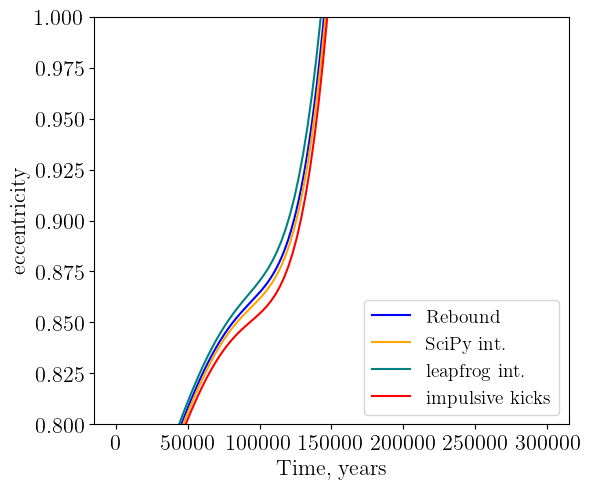

In [16]:
# comparison between the four approaches
fig=plt.figure()
plt.plot(itimes/tunit, fecc, color='blue', label='Rebound')
plt.plot(dir_res.t/tunit, dir_ecc, color='orange', label='SciPy int.')
plt.plot(t_eval/tunit, leap_ecc, color='teal', label='leapfrog int.')
plt.plot(tkicks/tunit, ecc_kicks, color='red', label='impulsive kicks')
plt.legend(loc='lower right')
plt.xlabel('Time, years')
plt.ylabel('eccentricity')
plt.ylim((0.8,1.0))
fig.tight_layout()
plt.show()


<h1>Same as above, but with time-varying functions m(t) and a(t) and without the Rebound comparison</h1>
<h3>Figures are showing for the configuration number 3, where the integration algorithms actually disagree. In configurations 1 and 2, the results of different integrators are the same. 

In [17]:
def config1():
    obj=Table()
    obj['m1']=np.array([4.3])
    obj['m2']=np.array([0.4])
    obj['fm1']=np.array([0.9])
    obj['sma']=np.array([8400.])
    obj['ecc']=np.array([0.68])
    obj['omega']=np.array([0.15])
    obj['asclong']=np.array([3.5])
    obj['mean_anomaly']=np.array([0.0])
    obj['inc']=np.array([0.44])
    return(obj)
obj=config1()
deltam=obj['m1']-obj['fm1']

In [18]:
def config2():
    obj=Table()
    obj['m1']=np.array([1.014651970470198])
    obj['m2']=np.array([0.3390443271235313])
    obj['fm1']=np.array([0.5701721576376159])
    obj['sma']=np.array([4722.487938896596])
    obj['ecc']=np.array([0.8331584788110833])
    obj['omega']=np.array([3.014525817978333])
    obj['asclong']=np.array([0.27571783348337137])
    obj['mean_anomaly']=np.array([5.107915076328847])
    obj['inc']=np.array([0.7702716903555991])
    return(obj)
obj=config2()
deltam=obj['m1']-obj['fm1']

In [19]:
def config3():
    obj=Table()
    obj['m1']=np.array([1.056428172496496])
    obj['m2']=np.array([0.4413572907944137])
    obj['fm1']=np.array([0.5735142537997197])
    obj['sma']=np.array([1418.2619737342914])
    obj['ecc']=np.array([0.037216869526488894])
    obj['omega']=np.array([0.33318508597823926])
    obj['asclong']=np.array([0.5357818879028051])
    obj['mean_anomaly']=np.array([4.932566075906491])
    obj['inc']=np.array([0.5227844540478073])
    return(obj)
obj=config3()
deltam=obj['m1']-obj['fm1']

In [20]:
# get the Cartesian initial coordinates for these orbital elements
print('period ',orbital.per(obj['m1']+obj['m2'],obj['sma']))
rvec0,vvec0=orbital.cart_from_orbital(obj['m1']+obj['m2'], obj['sma'], obj['ecc'], obj['inc'], 
                              obj['asclong'], obj['omega'], obj['mean_anomaly'])
rvec=rvec0[0]
vvec=vvec0[0]
print(rvec,vvec)

period         sma       
-----------------
43736.30785025995
[1112.02004417 -598.73211357 -623.82583059] [0.01731302 0.02656427 0.0080696 ]


In [21]:
# normalization in km/sec: 
vasym=1.0
tfinal=3e5*tunit
timestep=3e2*tunit

def tm(t, tf=tfinal):
# total mass is linearly declining to the final value, time is in code units
    return(obj['m1'][0]+obj['m2'][0]-deltam[0]*t/tf)
def ak(t, tf=tfinal):
# the time is in the code units and the acceleration is in the code units
# it's the object m1 that's losing the mass, so that's the normalization in the denominator
    return(vasym*vunit*deltam[0]/(obj['m1'][0]*tf-deltam[0]*t))
def vk(t,dt,tf=tfinal):
    # kick velocity -- I still can't figure out what the appropriate signs are
    # but it looks like I am adding a - sign to this during the actual intergration of kicks...
    # this is an integral of the acceleration from t to t+dt
    return(vasym*vunit*np.log((obj['m1'][0]*tf-deltam[0]*t)/(obj['m1'][0]*tf-deltam[0]*(t+dt))))


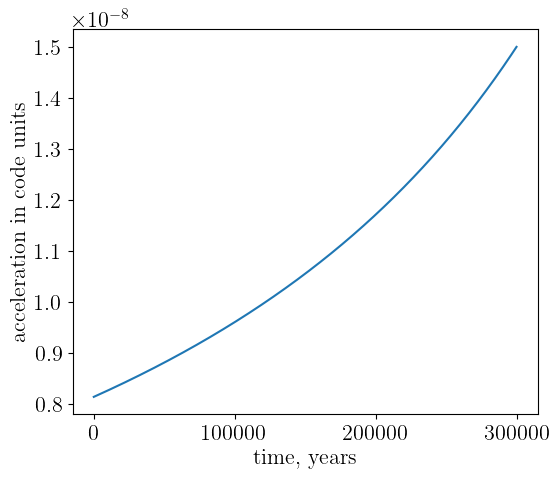

In [22]:
ttt=np.linspace(0,tfinal,10000)
fig=plt.figure()
plt.plot(ttt/tunit,ak(ttt))
plt.xlabel('time, years')
plt.ylabel('acceleration in code units')
plt.show()

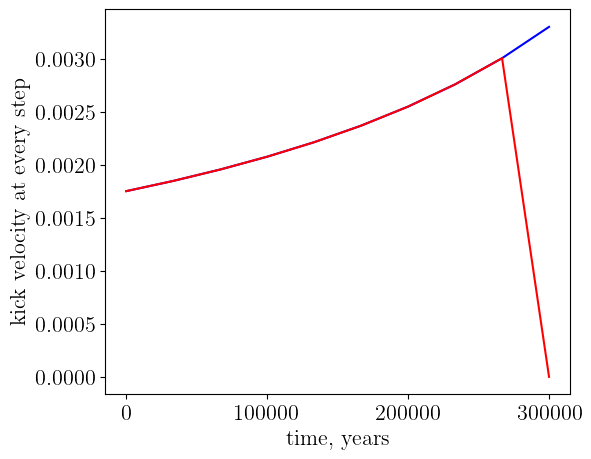

In [23]:
# let's compare the kick velocity per step based on the integral to just a times dt
nbins=10
tbins=np.linspace(0,tfinal,nbins)
vnum=np.zeros(len(tbins))
fig=plt.figure()
plt.plot(tbins/tunit,vk(tbins,tbins[1]-tbins[0]),color='blue')
for i,t in enumerate(tbins[0:len(tbins)-1]):
    ind=((ttt>=t) & (ttt<tbins[i+1]))
    vnum[i]=np.sum(ak(ttt)[ind])*(ttt[1]-ttt[0])
plt.plot(tbins/tunit,vnum,color='red')
plt.xlabel('time, years')
plt.ylabel('kick velocity at every step')
plt.show()
# they look pretty similar even in a very crude binning... 

In [24]:
# DIRECT integration by scipy:
minnum=100
deltat_code=orbital.per(obj['m1'][0]+obj['m2'][0],obj['sma'][0])*tunit/minnum
# this is the total number of steps: 
nsteps=max(minnum, int(tfinal/deltat_code))
t_eval=np.linspace(0, tfinal, nsteps)
def rhs(t, u): 
    r=np.sqrt(u[0]**2+u[1]**2+u[2]**2)
    return ([u[3],u[4],u[5],-tm(t)*u[0]/r**3,-tm(t)*u[1]/r**3,-tm(t)*u[2]/r**3+ak(t)])
dir_res = solve_ivp(rhs, (0, tfinal), [rvec[0], rvec[1], rvec[2], vvec[0], vvec[1], vvec[2]], t_eval=t_eval)
(dir_sma,dir_ecc,dir_inc,dir_asclong,dir_omega,dir_true)=orbital.orbital_from_cart(tm(dir_res.t),dir_res.y[0:3,].T,dir_res.y[3:6,].T)


In [25]:
# Series of kicks
nkicks=100
# time in code units
tkicks=np.linspace(0,tfinal,nkicks+1)
dt=tfinal/nkicks
# this is the eccentricity output
ecc_kicks=np.zeros(len(tkicks))
ecc_kicks[0]=obj['ecc'][0]
# this is the sma output
sma_kicks=np.zeros(len(tkicks))
sma_kicks[0]=obj['sma'][0]
# let's make the new evolving variable, it's a table of numpy arrays
orbit=Table(obj, copy=True)
for i in range(nkicks):
    if (orbit['ecc']<1.):
        # kick velocity in code units
        vkick=np.array([0.,0.,-vk(tkicks[i],dt)])
        # vkick=np.array([0.,0.,-ak(tkicks[i])*dt]) # its ounds like this will give a very similar result
        period=orbital.per(tm(tkicks[i]),orbit['sma'][0])
        orbit['mean_anomaly']=orbit['mean_anomaly']+2*np.pi*dt/period/tunit
        if (orbit['mean_anomaly']>2*np.pi): orbit['mean_anomaly']=orbit['mean_anomaly']-2*np.pi
        dm=np.array([tm(tkicks[i])-tm(tkicks[i+1])])
        new_orbit=orbital.one_kick_loss(orbit['m2'],orbit['m1'],dm,vkick,orbit)
        # this is going to be hacky... brace yourselves
        for key in new_orbit.keys(): orbit[key]=new_orbit[key][0]
        orbit['m1']=orbit['m1']-dm
    ecc_kicks[i+1]=orbit['ecc'][0]
    sma_kicks[i+1]=orbit['sma'][0]

In [26]:
# DIRECT integration by leapfrog
minnum=100
deltat_code=orbital.per(obj['m1'][0]+obj['m2'][0],obj['sma'][0])*tunit/minnum
# this is the total number of steps: 
nsteps=max(minnum, int(tfinal/deltat_code))
t_eval=np.linspace(0, tfinal, nsteps)
qqx=np.array([rvec[0]])
qqy=np.array([rvec[1]])
qqz=np.array([rvec[2]])
ppx=np.array([vvec[0]])
ppy=np.array([vvec[1]])
ppz=np.array([vvec[2]])
hh=t_eval[1]-t_eval[0]
for j in np.arange(1,nsteps):
    q12x=qqx[j-1]+0.5*hh*ppx[j-1]
    q12y=qqy[j-1]+0.5*hh*ppy[j-1]
    q12z=qqz[j-1]+0.5*hh*ppz[j-1]
    r=np.sqrt(q12x**2+q12y**2+q12z**2)
    t12=hh*j+0.5*hh
    ppx=np.concatenate((ppx,np.array([ppx[j-1]-hh*tm(t12)*q12x/r**3])))
    ppy=np.concatenate((ppy,np.array([ppy[j-1]-hh*tm(t12)*q12y/r**3])))
    ppz=np.concatenate((ppz,np.array([ppz[j-1]-hh*tm(t12)*q12z/r**3+hh*ak(t12)])))
    qqx=np.concatenate((qqx,np.array([q12x+0.5*hh*ppx[j]])))                   
    qqy=np.concatenate((qqy,np.array([q12y+0.5*hh*ppy[j]])))                   
    qqz=np.concatenate((qqz,np.array([q12z+0.5*hh*ppz[j]]))) 
qq=np.array([qqx,qqy,qqz]).T
pp=np.array([ppx,ppy,ppz]).T
(leap_sma,leap_ecc,leap_inc,leap_asclong,leap_omega,leap_true)=orbital.orbital_from_cart(tm(t_eval),qq,pp)

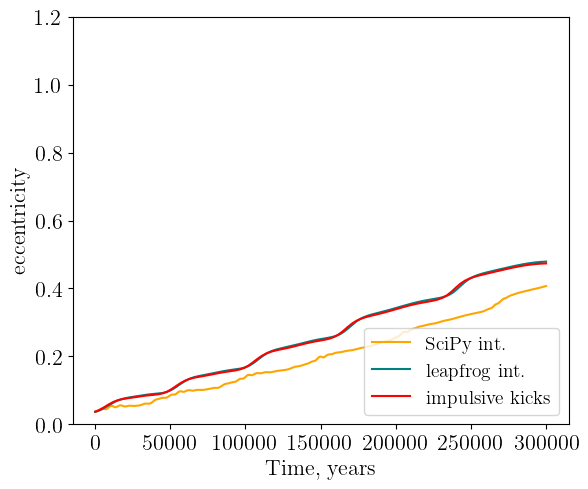

In [27]:
# comparison between the three approaches
fig=plt.figure()
plt.plot(dir_res.t/tunit, dir_ecc, color='orange', label='SciPy int.')
plt.plot(t_eval/tunit, leap_ecc, color='teal', label='leapfrog int.')
plt.plot(tkicks/tunit, ecc_kicks, color='red', label='impulsive kicks')
plt.legend(loc='lower right')
plt.xlabel('Time, years')
plt.ylabel('eccentricity')
plt.ylim((0.,1.2))
fig.tight_layout()
plt.show()


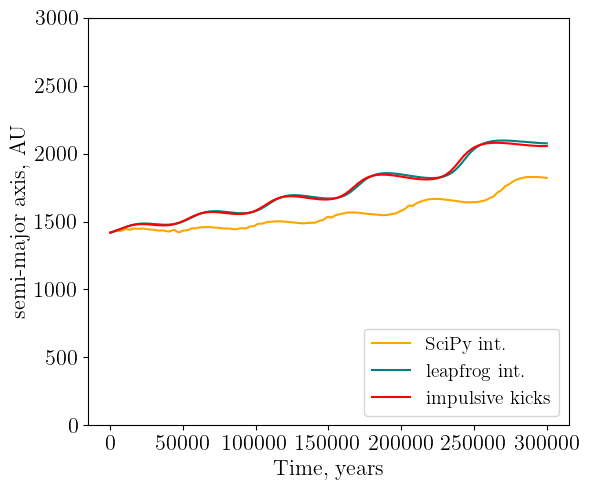

In [28]:
# comparison between the three approaches
fig=plt.figure()
plt.plot(dir_res.t/tunit, dir_sma, color='orange', label='SciPy int.')
plt.plot(t_eval/tunit, leap_sma, color='teal', label='leapfrog int.')
plt.plot(tkicks/tunit, sma_kicks, color='red', label='impulsive kicks')
plt.legend(loc='lower right')
plt.xlabel('Time, years')
plt.ylabel('semi-major axis, AU')
plt.ylim((0.,3e3))
fig.tight_layout()
plt.show()

<h3>Conclusions:</h3>
<p>I have purposefully chosen a similar number of steps (100) for all integrators (except Rebound which did its own thing), and I have purposefully chosen a number of steps that's not too high so that any numerical issues would be noticeable. I conclude that leapfrog reliably performs well and use that in the stellar population model. Something goes wrong with the SciPy algorithm in the 3rd orbital configuration. 
<p>Even though impulsive kicks perform impressively well too (perhaps because between the impulsive kicks and as a result of the impulsive kicks the solution is purely analytical), we are not going to use them sequentially like I did here, only for the cases when the orbital period is truly significantly longer than the mass loss timescale. 